Import packages and functions

In [7]:
import sys
import os
sys.path.append('../')

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nustar_scripts.nu_pyxspec import scan_containers_ph_res, ph_res_param, Model, Fit, Plot, xspec,  AllModels
from nustar_scripts.nu_utils import set_mpl, fits
from nustar_scripts.nu_class import NustarObservation, glob
from nustar_scripts.pulsar_init import Nu_path, ObsList_bright, plot_path, ObsAlias, analysis_path
import matplotlib
%matplotlib inline 

AllModels.lmod('relxill', '/Users/sdbykov/work/xray_pulsars/sj0243_nu/python_for_nustar/relxill_model/') #set path to relxill model




In [9]:
set_mpl('Pastel2')

Define necessary functions

In [10]:
def plot_pulse_profile(ObsID, ax_pp):
    """  plots pulse profile of the observation on a given axis"""

    ff_zero = fits.open(f'{analysis_path}out{ObsID}/products/phase_resolved/phase_resolved_bin1AB_sr.lc_bary_orb_corr_nphase_128.efold')
    phase_zero = ff_zero[1].data["PHASE"]
    rate_zero = ff_zero[1].data["RATE1"]
    idx = np.where(~np.isnan(rate_zero))[0][0]
    ph_shift = phase_zero[idx] * (-1)

    f   = fits.open(f'{analysis_path}out{ObsID}/products/spe_and_lc/spe_and_lcAB_sr.lc_bary_orb_corr_nphase_128.efold')
    ph, rate, err = f[1].data['PHASE']+ ph_shift,  f[1].data['RATE1'],  f[1].data['ERROR1']
    roll_idx  = 0
    rate = np.roll(rate, roll_idx)
    err = np.roll(err, roll_idx)

    rate = np.tile(rate, 2)
    err = np.tile(err, 2)
    ph = np.hstack((ph, ph+1))

    ax_pp.step(ph, rate, where='mid', color = 'k', alpha = 0.7)
    return ph, rate


# Ratio to  cutoffpl

In [11]:

def plot_po_rat(
    ObsID: str,
    bin_numbers: list,
    ax: plt.Axes,
    min_sig: int = 120,
    gamma: str = '2',
    ecut: str = '40',
    ):
    """
    plot_po_rat plots the ration of the spectra of a phase bin to the cutoffpl model. Also plots  the pulse profile and the appropriate phase  interval

    Args:
        ObsID (str): ObsID
        bin_numbers (list): list of bin numbers
        ax (plt.Axes): axis to plot on
        min_sig (int, optional): rebinning of the spectral plot. Defaults to 120.
        gamma (str, optional): photon index. Defaults to '2'.
        ecut (str, optional): cutoff energy in keV. Defaults to '40'.

    """
    ms, alpha, lw = 4, 0.5, 0


    ax_pp = ax.inset_axes([0.3, 0.1, 0.4, 0.2])
    plot_pulse_profile(ObsID, ax_pp)
    ax_pp.tick_params(axis='both',which='both',labelbottom=False,bottom=False,top = False,left=False)
    ax_pp.set_yticks([]) 
    
    colors  = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
    for bin_number, color in zip(bin_numbers,colors):
        os.chdir(f"{analysis_path}out{ObsID}/products/phase_resolved")
        xspec.AllData.clear()
        xspec.AllModels.clear()
        xspec.Xset.restore(f'./xspec/relxilllp/xcm/{ObsID}_bin{bin_number}_relxilllp.xcm')

        mo_loaded = xspec.AllModels(1)
        refl_fract = mo_loaded.relxilllp.refl_frac.values[0]
        refl_fract = f"{refl_fract:.2f}"
        print(f"Obs {ObsID}; bin {bin_number}; refl_factor = {refl_fract}")
        mo_loaded.relxilllp.refl_frac = '0 -1'

        mo_cutoffpl = Model("const*cutoffpl")
        mo_cutoffpl.cutoffpl.PhoIndex = str(gamma) + ' -1'
        mo_cutoffpl.cutoffpl.HighECut = str(ecut) + ' -1'

        mo_cutoffpl.setPars({1: '1. -1'})
        m2 = AllModels(2)
        m2.setPars({1: '1. '})
        Fit.query = 'yes'
        Fit.statMethod = "chi"
        Fit.query = "yes"
        Fit.perform()

        label = f'Bin {bin_number}; $f_{{refl}}$ = {refl_fract}'
        
        for gr, m, l in zip([1,2], ['o', 's'], [label, '_'+ label]):

            Plot.device = "/null"
            Plot.setRebin(min_sig, min_sig)
            Plot("rat")
            Plot.xAxis = "keV"
            en = np.array(Plot.x(gr))
            data = np.array(Plot.y(gr))
            en_err = np.array(Plot.xErr(gr))
            data_err = np.array(Plot.yErr(gr))

            color = color
            ax.semilogx(en, data, marker = m, lw = lw, alpha = alpha, ms = ms, color = color)   
            ax.errorbar(en, data, data_err, en_err,
                            fmt='none', ecolor=color, alpha=alpha*0.7, label=l,)
            if gr==1:
                b = bin_number
                ax_pp.axvspan((b-1)/10, b/10, color = color, alpha = 0.4)




        ax.set_xscale("log")
        ax.set_xlabel("Energy (keV)")

        ax.set_ylabel(f"Ratio to cutoffpl,\n $\Gamma$={gamma}; $E_{{cut}}$={ecut} keV", fontsize = 14)
        l = ax.legend(loc="lower left", title = ObsAlias[ObsID], fontsize = 10,  title_fontsize = 10)
        l.set_zorder(-1)
        for lh in l.legendHandles:
            lh.set_alpha(1)
        ax.set_xticks([4, 6, 7, 10, 20, 40, 80])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())



    return fig, ax



Obs 90302319004; bin 7; refl_factor = 0.12
Obs 90302319004; bin 4; refl_factor = 0.34
Obs 90302319006; bin 2; refl_factor = 0.16
Obs 90302319006; bin 5; refl_factor = 0.48
Obs 90302319006; bin 7; refl_factor = 0.21
Obs 90302319008; bin 4; refl_factor = 0.08
Obs 90302319008; bin 1; refl_factor = 0.16


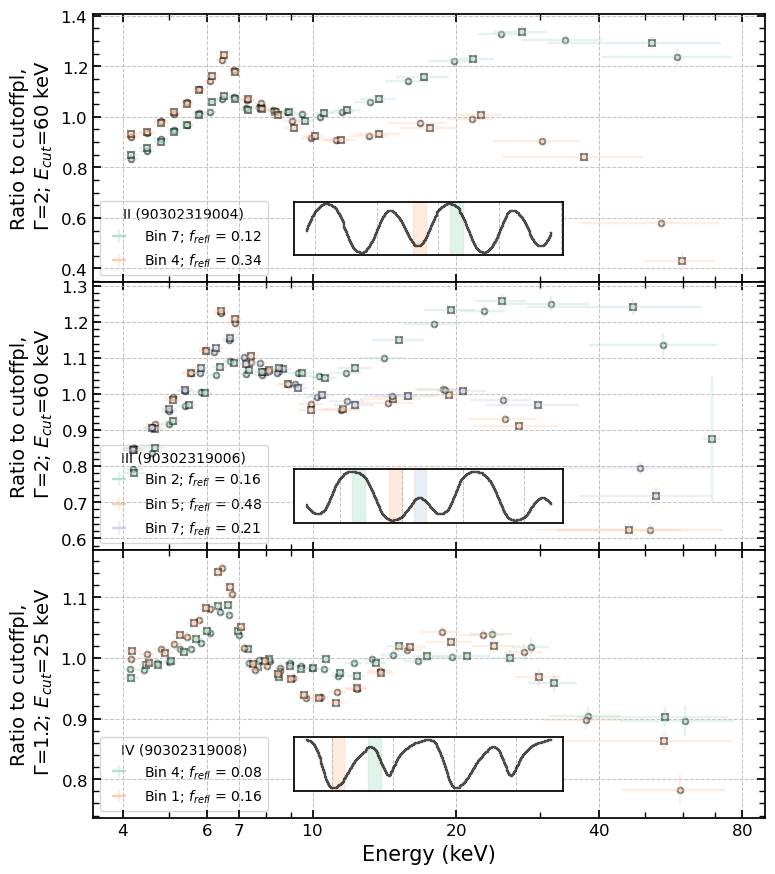

In [12]:
fig,  [ax1,ax2,ax3] =  plt.subplots(3, figsize = (8,9), sharex=True, gridspec_kw = {'hspace':0})
plot_po_rat('90302319004', [7,4], ecut = '60', ax = ax1)
plot_po_rat('90302319006', [2,5,7], ecut = '60', ax = ax2)
plot_po_rat('90302319008', [4,1], ecut = '25', gamma='1.2', ax = ax3)

fig.tight_layout()
fig.savefig(plot_path+ '/ph-res/cutoffpl_ratio.pdf')